# Model Fitting

In [3]:
import numpy as np
from numpy import sin, pi

def sine_model(t, B, A, P, t0):
    return A * sin((t / P + t0) * 2 * pi) + B

In [4]:
np.random.seed(42)

n_data = 20

# time of observations
t = np.random.uniform(0, 5, size=n_data)

# measurement values
yerr = 1.0
y = np.random.normal(sine_model(t, A=4.2, P=3, t0=0, B=1.0), yerr)

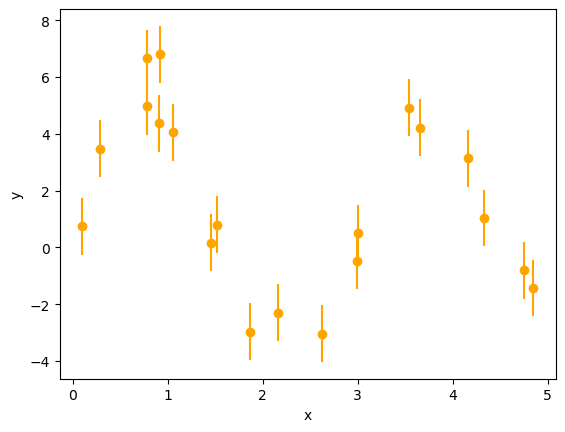

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange');

In [6]:
parameters = ['B', 'A', 'P', '$t_0$']

def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let background level go from -10 to +10
    params[0] = cube[0] * 20 - 10
    # let amplitude go from 0.01 to 100
    params[1] = 10**(cube[1] * 4 - 2)
    # let period go from 0.3 to 30
    params[2] = 10**(cube[2] * 2)
    # let time go from 0 to 1
    params[3] = cube[3]
    return params

In [7]:
import scipy.stats

def log_likelihood(params):
    # unpack the current parameters:
    B, A, P, t0 = params

    # compute for each x point, where it should lie in y
    y_model = sine_model(t, A=A, B=B, P=P, t0=t0)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()

    return loglike

In [8]:
from ultranest import ReactiveNestedSampler

sampler = ReactiveNestedSampler(parameters, log_likelihood, prior_transform,
    wrapped_params=[False, False, False, True],
)

In [9]:
result = sampler.run(min_num_live_points=400, dKL=np.inf, min_ess=100)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  61 [-7.7535..-7.7531]*| it/evals=7920/51796 eff=15.4098% N=400 0     0  
[ultranest] Likelihood function evaluations: 51810
[ultranest]   logZ = -22.9 +- 0.1181
[ultranest] Effective samples strategy satisfied (ESS = 2138.5, need >100)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <inf nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.


In [14]:
sampler.print_results()


logZ = -22.918 +- 0.291
  single instance: logZ = -22.918 +- 0.182
  bootstrapped   : logZ = -22.898 +- 0.291
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    B                   : -0.45 │ ▁ ▁▁▁▁▁▁▁▁▂▂▃▄▅▅▆▇▇▇▆▆▅▄▃▂▁▁▁▁▁▁▁▁▁ ▁ │1.81      0.67 +- 0.25
    A                   : 2.94  │ ▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▅▆▇▇▆▇▅▅▄▃▂▂▂▁▁▁▁▁▁▁ ▁ │5.80      4.37 +- 0.35
    P                   : 2.719 │ ▁▁▁▁▁▁▁▁▁▁▂▃▄▄▆▅▇▇▇▆▇▇▆▅▄▃▃▂▁▁▁▁▁▁▁ ▁ │3.268     2.998 +- 0.070
    $t_0$               : 0.00  │▅▁▁                                ▁▁▃▇│1.00      0.64 +- 0.46



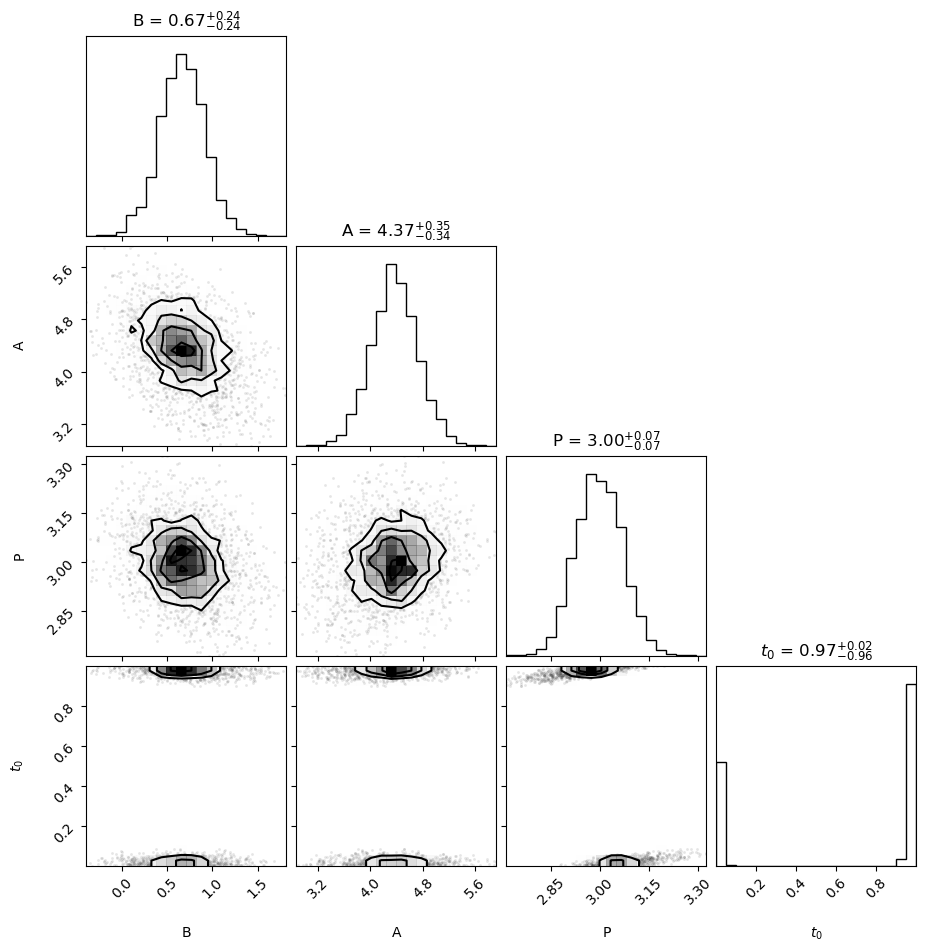

In [15]:
from ultranest.plot import cornerplot
cornerplot(result)

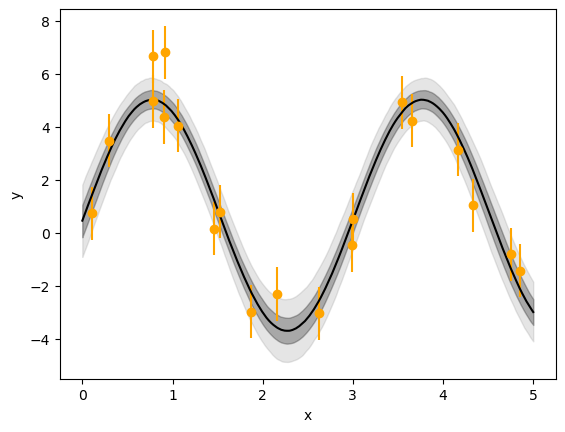

In [16]:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange')


t_grid = np.linspace(0, 5, 400)

from ultranest.plot import PredictionBand
band = PredictionBand(t_grid)

# go through the solutions
for B, A, P, t0 in sampler.results['samples']:
    # compute for each time the y value
    band.add(sine_model(t_grid, A=A, B=B, P=P, t0=t0))

band.line(color='k')
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)

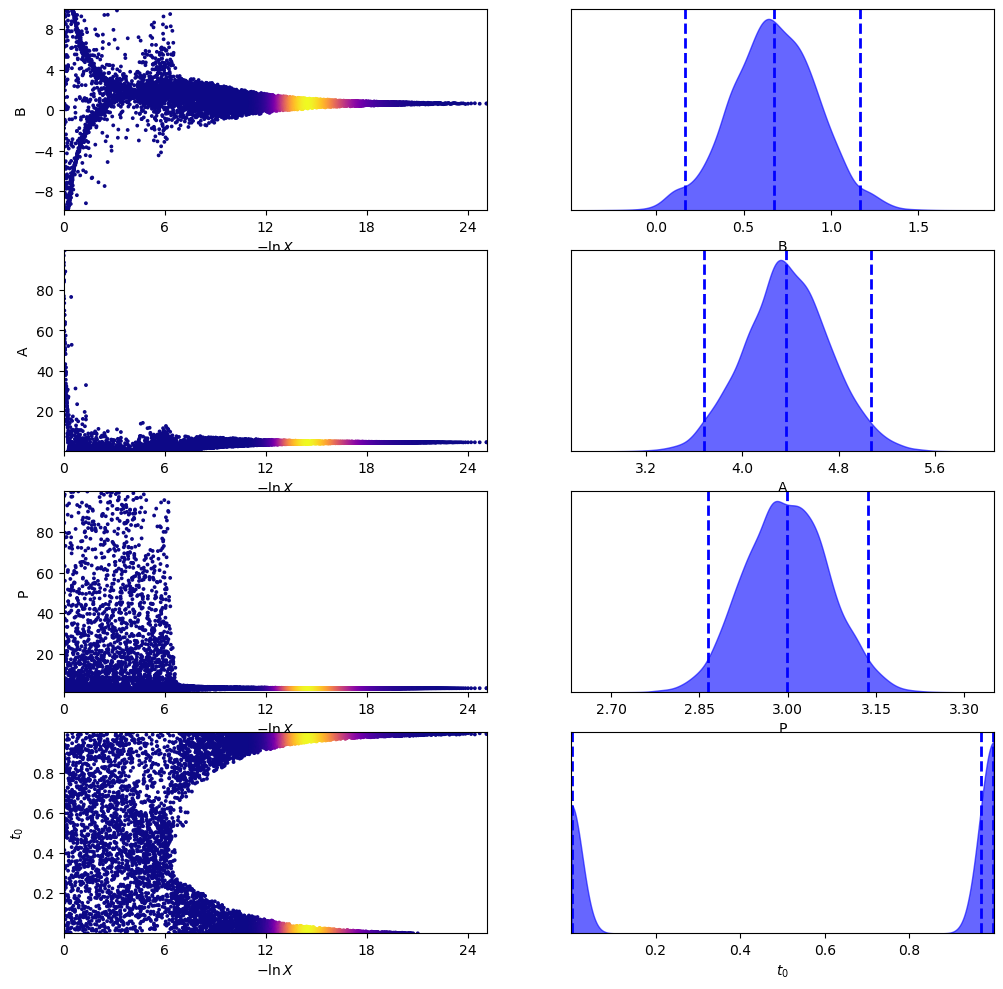

In [17]:
sampler.plot_trace()

# Model Comparison

In [3]:
import numpy as np
from numpy import pi, sin
import ultranest

def sine_model1(t, B, A1, P1, t1):
    return A1 * sin((t / P1 + t1) * 2 * pi) + B

def sine_model0(t, B):
    return B + t*0

In [4]:
np.random.seed(42)

n_data = 50

# time of observations
t = np.random.uniform(0, 5, size=n_data)
# measurement values
yerr = 1.0
y = np.random.normal(sine_model1(t, B=1.0, A1=0.9, P1=3, t1=0), yerr)

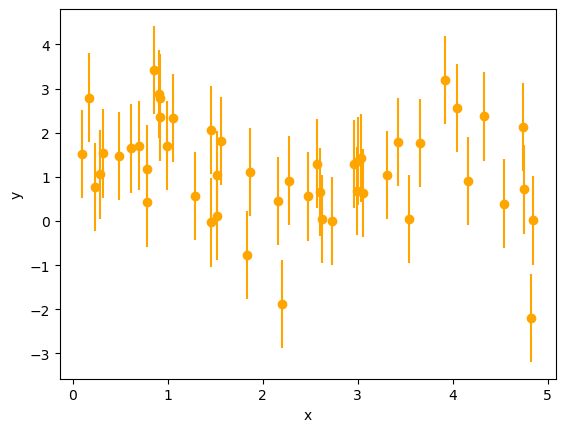

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange')
t_range = np.linspace(0, 5, 1000)

In [6]:
parameters1 = ['B', 'A1', 'P1', 't1']

def prior_transform1(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let background level go from -10 to +10
    params[0] = cube[0] * 20 - 10
    # let amplitude go from 0.1 to 100
    params[1] = 10**(cube[1] * 3 - 1)
    # let period go from 1 to 100
    params[2] = 10**(cube[2] * 2)
    # let time go from 0 to 1
    params[3] = cube[3]
    return params

parameters0 = ['B']

def prior_transform0(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let background level go from -10 to +10
    params[0] = cube[0] * 20 - 10
    return params

In [7]:
def log_likelihood1(params):
    # unpack the current parameters:
    B, A1, P1, t1 = params

    # compute for each x point, where it should lie in y
    y_model = sine_model1(t, B=B, A1=A1, P1=P1, t1=t1)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()

    return loglike

def log_likelihood0(params):
    B, = params

    y_model = sine_model0(t, B=B)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()

    return loglike

In [8]:
sampler1 = ultranest.ReactiveNestedSampler(parameters1, log_likelihood1, prior_transform1)

sampler0 = ultranest.ReactiveNestedSampler(parameters0, log_likelihood0, prior_transform0)

In [9]:
result1 = sampler1.run(min_num_live_points=400)
sampler1.print_results()

[ultranest] Sampling 400 live points from prior ...


KeyboardInterrupt: 

In [ ]:
result0 = sampler0.run(min_num_live_points=400)
sampler0.print_results()

In [ ]:
from ultranest.plot import cornerplot
cornerplot(result1)

In [ ]:
cornerplot(result0)

In [ ]:
plt.figure()
plt.title("1-sine fit")
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange')

t_grid = np.linspace(0, 5, 400)

from ultranest.plot import PredictionBand
band = PredictionBand(t_grid)

# go through the solutions
for B, A1, P1, t1 in sampler1.results['samples']:
    # compute for each time the y value
    band.add(sine_model1(t_grid, B=B, A1=A1, P1=P1, t1=t1))

band.line(color='k')
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)

In [ ]:
plt.figure()
plt.title("Noise fit")
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange')

t_grid = np.linspace(0, 5, 400)

from ultranest.plot import PredictionBand
band = PredictionBand(t_grid)

# go through the solutions
for B in sampler0.results['samples']:
    # compute for each time the y value
    band.add(sine_model0(t_grid, B=B))

band.line(color='k')
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)

In [ ]:
K = np.exp(result1['logz'] - result0['logz'])
print("K = %.2f" % K)
print("The 1-sine model is %.2f times more probable than the no-signal model" % K)
print("assuming the models are equally probable a priori.")

In [ ]:
import logging
logging.getLogger('ultranest').setLevel(logging.FATAL)

In [21]:
K_simulated = []

import logging
logging.getLogger('ultranest').handlers[-1].setLevel(logging.FATAL)

# go through 100 plausible parameters
for B in sampler0.results['samples'][:50]:
    # generate new data
    y = np.random.normal(sine_model0(t, B=1.0), yerr)

    # analyse with sine model
    sampler1 = ultranest.ReactiveNestedSampler(parameters1, log_likelihood1, prior_transform1)
    Z1 = sampler1.run(viz_callback=False)['logz']
    # analyse with noise-only model
    sampler0 = ultranest.ReactiveNestedSampler(parameters0, log_likelihood0, prior_transform0)
    Z0 = sampler0.run(viz_callback=False)['logz']
    # store Bayes factor
    K_here = Z1 - Z0
    K_simulated.append(K_here)
    print()
    print("Bayes factor: %.2f" % np.exp(K_here))

AttributeError: 'ReactiveNestedSampler' object has no attribute 'results'

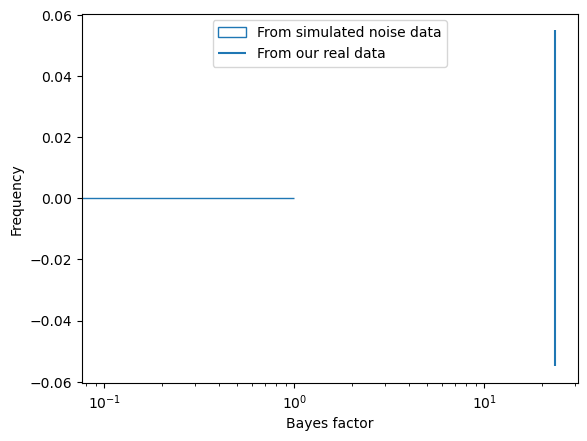

In [55]:
plt.figure()
plt.hist(np.exp(K_simulated), histtype='step', label='From simulated noise data')
ylo, yhi = plt.ylim()
plt.vlines(K, ylo, yhi, label='From our real data')
plt.xscale('log')
plt.xlabel('Bayes factor')
plt.ylabel('Frequency')
plt.legend(loc='upper center');

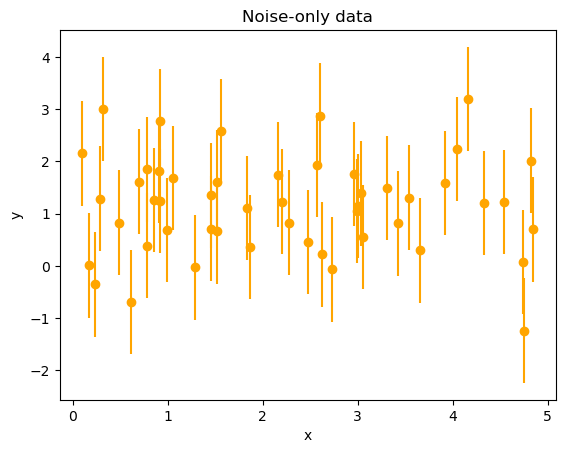

In [24]:
y = np.random.normal(sine_model0(t, B=1.0), yerr)
plt.figure()
plt.title("Noise-only data")
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls='', color='orange')

t_grid = np.linspace(0, 5, 400)

# Intrinsic Distribution

In [25]:
import numpy as np
# velocity dispersions of dwarf galaxies by van Dokkum et al., Nature, 555, 629 https://arxiv.org/abs/1803.10237v1

values = np.array([15, 4, 2, 11, 1, -2, -1, -14, -39, -3])
values_lo = np.array([7, 16, 6, 3, 6, 5, 10, 6, 11, 13])
values_hi = np.array([7, 15, 8, 3, 6, 6, 10, 7, 14, 14])

n_data = len(values)

(-50.0, 50.0)

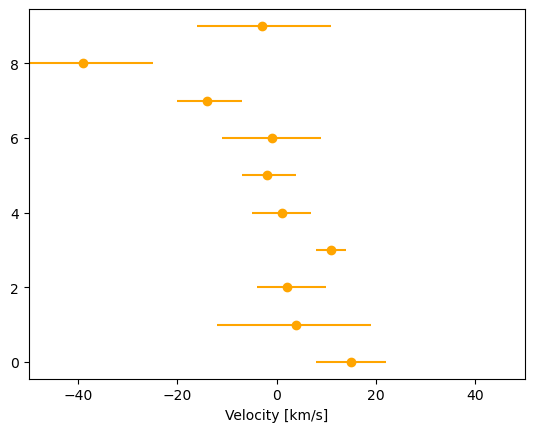

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
xlabel = 'Velocity [km/s]'
plt.xlabel(xlabel)
plt.errorbar(x=values, xerr=[values_lo, values_hi], y=range(n_data),
             marker='o', ls=' ', color='orange')
plt.xlim(-50, 50)

Text(0.5, 0, 'Velocity [km/s]')

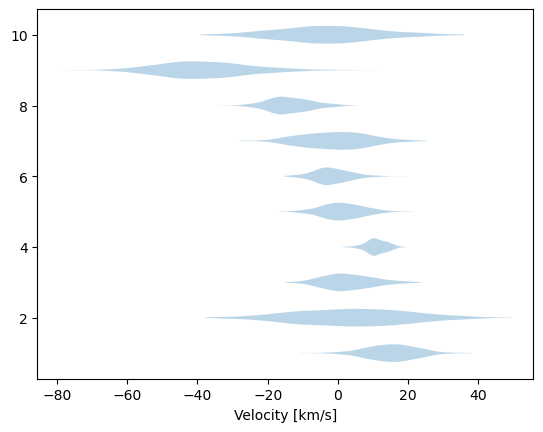

In [27]:
samples = []

for i in range(n_data):
    # draw normal random points
    u = np.random.normal(size=400)
    v = values[i] + np.where(u < 0, u * values_lo[i], u * values_hi[i])

    samples.append(v)

samples = np.array(samples)

plt.figure()
# for each galaxy, plot alittle cloud with its own colors
plt.violinplot(samples.transpose(), vert=False, showextrema=False)

plt.xlabel(xlabel)

In [28]:
parameters = ['mean', 'scatter']

def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let slope go from -3 to +3
    lo = -100
    hi = +100
    params[0] = cube[0] * (hi - lo) + lo
    # let scatter go from 1 to 1000
    lo = np.log10(1)
    hi = np.log10(1000)
    params[1] = 10**(cube[1] * (hi - lo) + lo)
    return params

In [29]:
import scipy.stats

def log_likelihood(params):
    # unpack the current parameters:
    mean, scatter = params

    # compute the probability of each sample
    probs_samples = scipy.stats.norm(mean, scatter).pdf(samples)
    # average over each galaxy, because we assume one of the points is the correct one (logical OR)
    probs_objects = probs_samples.mean(axis=1)
    assert len(probs_objects) == n_data
    # multiply over the galaxies, because we assume our model holds true for all objects (logical AND)
    # for numerical stability, we work in log and avoid zeros
    loglike = np.log(probs_objects + 1e-100).sum()
    return loglike

In [30]:
import ultranest

sampler = ultranest.ReactiveNestedSampler(parameters, log_likelihood, prior_transform)

In [31]:
result = sampler.run()

[ultranest] Sampling 400 live points from prior ...
[ultranest] Widening roots to 403 live points (have 400 already) ...
[ultranest] Sampling 3 live points from prior ...


[ultranest] Explored until L=-4e+01   [-39.6648..-39.6648]*| it/evals=3740/5459 eff=73.9122% N=400   
[ultranest] Likelihood function evaluations: 5475
[ultranest]   logZ = -44.42 +- 0.08549
[ultranest] Effective samples strategy satisfied (ESS = 1655.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.


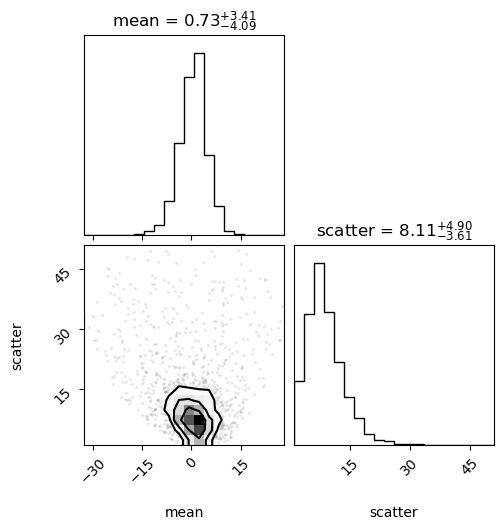

In [32]:
from ultranest.plot import cornerplot
cornerplot(result)

[ultranest] Widening roots to 400 live points (have 403 already) ...
[ultranest] Explored until L=-4e+01  
[ultranest] Likelihood function evaluations: 5475
[ultranest]   logZ = -44.44 +- 0.07248
[ultranest] Effective samples strategy wants to improve: -47.97..-39.66 (ESS = 1655.3, need >4000)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.01 total:0.07 required:<0.50
[ultranest] Widening from 366 to 800 live points before L=-5e+01...
[ultranest] parent value is -inf, so widening roots
[ultranest] Widening roots to 800 live points (have 403 already) ...
[ultranest] Sampling 397 live points from prior ...
[ultranest] Exploring (in particular: L=-inf..-39.66) ...


[ultranest] Explored until L=-4e+01   [-inf..-39.66] | it/evals=9143/12831 eff=77.4249% N=795 
[ultranest] Likelihood function evaluations: 12845
[ultranest]   logZ = -44.4 +- 0.06458
[ultranest] Effective samples strategy wants to improve: -47.91..-39.65 (ESS = 3300.8, need >4000)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.06, need <0.5)
[ultranest]   logZ error budget: single: 0.07 bs:0.06 tail:0.00 total:0.06 required:<0.50
[ultranest] Widening from 728 to 1590 live points before L=-5e+01...
[ultranest] parent value is -inf, so widening roots
[ultranest] Widening roots to 1590 live points (have 800 already) ...
[ultranest] Sampling 790 live points from prior ...
[ultranest] Exploring (in particular: L=-inf..-39.66) ...
[ultranest] Explored until L=-4e+01   [-inf..-39.66] | it/evals=18525/25343 eff=79.9283% N=1572  
[ultranest] Likelihood function evaluations: 25350
[ultr

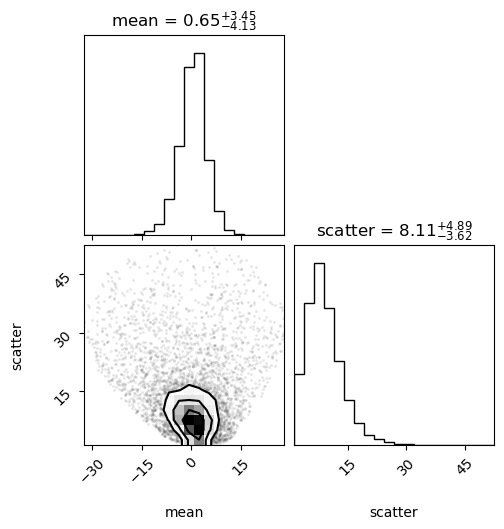

In [33]:
# ask for more samples: increasing the required effective sample size
result = sampler.run(min_ess=4000)
cornerplot(result)

In [34]:
mean_samples, scatter_samples = result['samples'].transpose()

# get 3 sigma quantile
quantile = scipy.stats.norm().cdf(3)

# look at the value:
print('scatter is < %.4f km/s at 3 sigma (%.3f%% quantile)' % (scipy.stats.mstats.mquantiles(scatter_samples, quantile), quantile*100))

scatter is < 32.5653 km/s at 3 sigma (99.865% quantile)


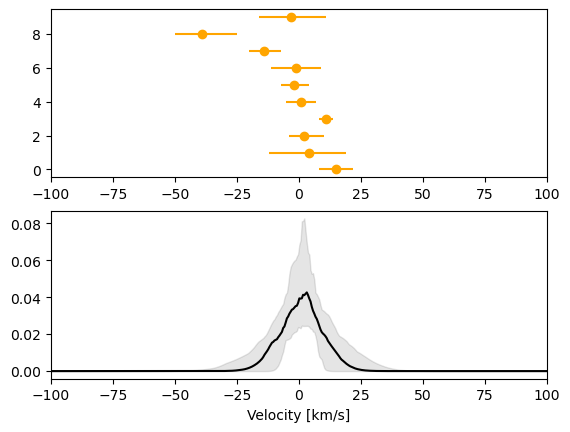

In [35]:
plt.figure()

plt.subplot(2, 1, 1)
plt.errorbar(x=values, xerr=[values_lo, values_hi], y=range(n_data),
             marker='o', ls=' ', color='orange')
plt.xlim(-100, 100)

plt.subplot(2, 1, 2)
plt.xlim(-100, 100)
plt.xlabel(xlabel)

from ultranest.plot import PredictionBand
x = np.linspace(-100, 100, 400)
band = PredictionBand(x)
bandc = PredictionBand(x)

for params in sampler.results['samples'][:40]:
    mean, scatter = params
    band.add(scipy.stats.norm(mean, scatter).pdf(x))

band.shade(color='k', alpha=0.1)
band.line(color='k')